# This notebook performs the iterative estimation of 2508.21131 including frequency correlations, but assuming frequency and angular structure to factorize

### - Start importing all libraries

In [ ]:
# Global imports
import sys
import tqdm
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

sys.path.append("../")

# Local imports
import examples_utils as eu
from fastPTA import get_tensors as gt
from fastPTA import utils as ut
from fastPTA.data import generate_data as gd
from fastPTA import generate_new_pulsar_configuration as gnpc
from fastPTA.angular_decomposition import spherical_harmonics as sph
from fastPTA.data import data_correlations as dc
from fastPTA.inference_tools import iterative_estimation as ie

print(eu.path_to_file)
%reload_ext autoreload
%autoreload 2
jax.config.update("jax_enable_x64", True)

### - Define some constants

In [17]:
# Number of external frequency bins to use in the analysis
nfreqs = 15

# Time span of the observation
Tspan_yrs = 16.0

# Time span in seconds
Tspan = Tspan_yrs * ut.yr

# Number of pulsars to simulate
npulsars = 50

### - Define interal/external frequency vectors and the spectral shapes

In [18]:
# Delta frequency for the internal frequency vector
df_step = 0.1

# Initial frequency for the internal frequency vector
f_in = 0.1

# External frequency vector
fi = jnp.arange(1, nfreqs + 1) / Tspan

# Internal frequency vector
ff = jnp.arange(f_in, nfreqs + 1, step=df_step) / Tspan

# Spectrum evaluated in the external frequencies
S_ff = (ff / ut.f_yr) ** -2

# Spectrum evaluated in the internal frequencies
S_fi = (fi / ut.f_yr) ** -2

### - Choose the pixelization of the sky and l_max

In [19]:
Nside = 8
l_max = 3

n_params = sph.get_n_coefficients_real(l_max)

### - Define the injection and get the theoretical sky map 

In [20]:
# Initialize the real C_lm coefficients
clms_real = np.zeros(n_params)

# Add the monopole (with the right normalization)
clms_real[0] = 1 / np.sqrt(4 * np.pi)

# Add a dipole (optional)
clms_real[2] = 1 / np.sqrt(4 * np.pi) / np.sqrt(3)

# Get the map from the real C_lm coefficients
Pk = sph.get_map_from_real_clms(clms_real, Nside, l_max=l_max)

# Full spectrum (external frequency \times angular structure)
H_p_ff = Pk[:, None] * S_ff[None, :]

### - Generate random pulsar positions and distances

In [21]:
# Generate pulsar sky positions and distances
p_vec, cos_IJ, distances, theta_k, phi_k = gd.generate_pulsar_sky_and_kpixels(
    npulsars, Nside
)

# Convert distance from pc to meters
distances *= ut.parsec

# Compute Hellings-Downs correlations
HD_IJ = gt.HD_correlations(cos_IJ)

### - Compute the gamma_IJ_lm

In [22]:
gamma_IJ_lm = gt.get_correlations_lm_IJ(p_vec, l_max, Nside)

### - Run the iterative estimate several times

In [ ]:
# Choose the number of runs to perform
N_runs = 300

# Initialize arrays to hold the means and standard deviations
means = np.zeros((N_runs, n_params))
stds = np.zeros((N_runs, n_params))

# Initial guess (quite far away from the true values)
full_guess = np.zeros(n_params)
full_guess[0] = np.sqrt(4 * np.pi)
full_guess *= 10

# Get the normalization of the ff correlation matrix
C_ff = dc.get_D_IJ_fifj_normalization(Tspan, fi, ff, H_p_ff)

# Get its inverse
inv_ff = ut.compute_inverse(C_ff)

# Since the frequency structure will be diagonalized, just rescale with the right normalization
f0 = fi**0
S_f0 = 3 / 4 * (2 * jnp.pi) ** 2 * S_fi**0
    
# Perform the runs in a for loop
for nn in tqdm.tqdm(range(N_runs)):

    # Generate a random realization of the GWB
    h_tilde = gd.generate_hpc_polarization_pixel_frequency(H_p_ff)

    # Compute the data correlation D_IJ
    D_IJ = dc.get_D_IJ_fifj(
        Tspan, fi, ff, h_tilde, distances, p_vec, theta_k, phi_k
    )

    # Multiply D_IJ by the inverse of the ff correlation matrix,
    # with this the ff part becomes diagonal!
    rescale_D_IJ = jnp.diagonal(
        jnp.einsum("fg,glab->flab", inv_ff, D_IJ), axis1=0, axis2=1
    ).T

    # Get the estimated values for the parameters
    theta, uncertainties, _ = ie.iterative_estimation(
        ie.get_update_estimate_diagonal,
        full_guess,
        rescale_D_IJ,
        gamma_IJ_lm,
        f0,
        S_f0,
    )

    # Update the corresponding mean and std
    means[nn] = theta
    stds[nn] = uncertainties

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [02:34<00:00,  1.95it/s]


### - Filter nans (we can get some in the minimization if the uncertainties are too large)

In [24]:
means = means[~np.isnan(stds).any(axis=1)]
stds = stds[~np.isnan(stds).any(axis=1)]
stds = stds[~np.isnan(means).any(axis=1)]
means = means[~np.isnan(means).any(axis=1)]

### - Plot the histograms for all our runs

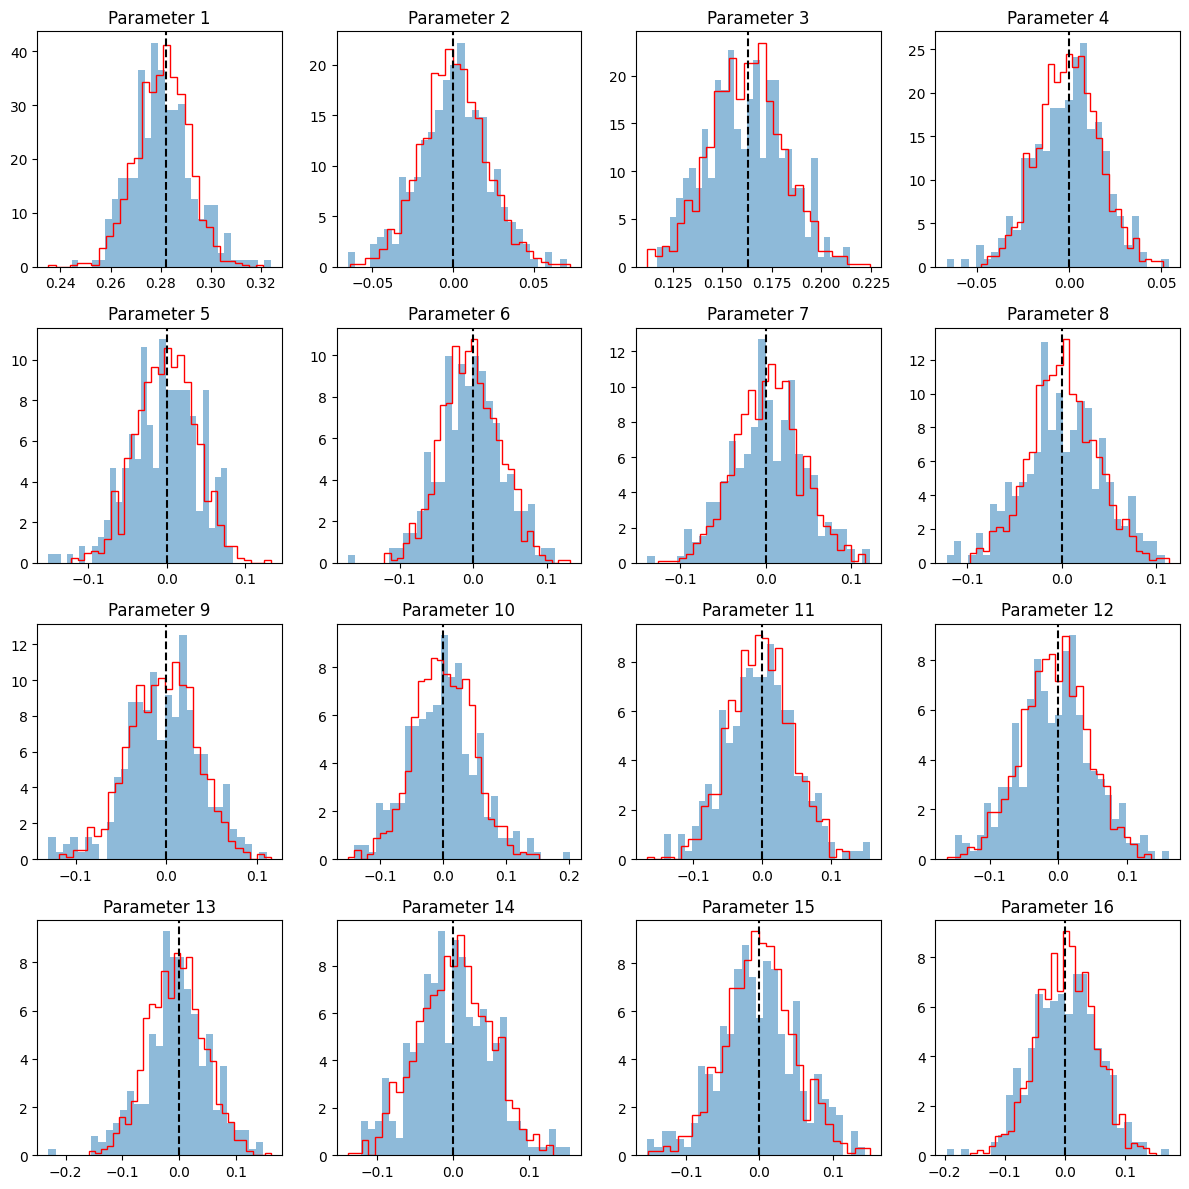

In [25]:
nplots = sph.get_n_coefficients_real(l_max)
ncols = 4
n_bins = 30


fig, ax = plt.subplots(ncols=ncols, nrows=int(nplots / ncols), figsize=(12, 12))


for i in range(nplots):
    # Plot the histogram of the means
    ax[int(i / 4), i % 4].hist(
        means[:, i], bins=n_bins, density=True, alpha=0.5
    )

    # Generate Gaussian random data with
    # mean = mean of the means
    # std = mean of stds
    gauss = np.random.normal(np.mean(means[:, i]), np.mean(stds[:, i]), (1000))

    # Plot the histogram of the Gaussian random data
    ax[int(i / 4), i % 4].hist(
        gauss, bins=n_bins, density=True, histtype="step", color="red"
    )

    # Plot the true value
    ax[int(i / 4), i % 4].axvline(
        clms_real[i], color="black", linestyle="dashed"
    )

    ax[int(i / 4), i % 4].set_title(f"Parameter {i + 1}")

plt.tight_layout()

### - As above but subtracting the mean and rescaling by the std

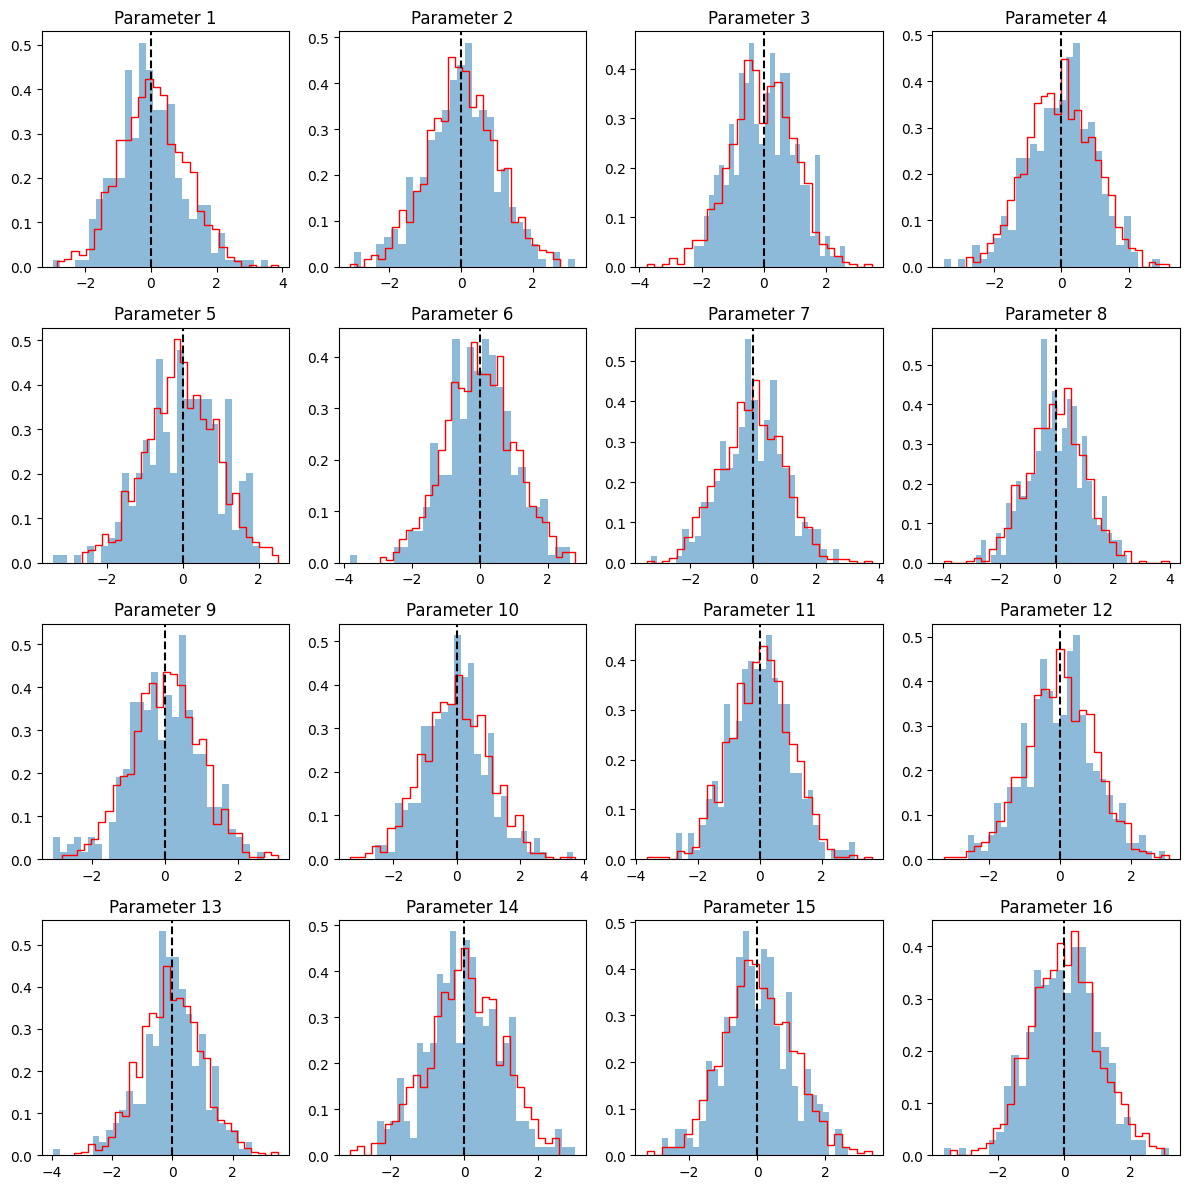

In [26]:
nplots = sph.get_n_coefficients_real(l_max)
ncols = 4
n_bins = 30


fig, ax = plt.subplots(ncols=ncols, nrows=int(nplots / ncols), figsize=(12, 12))


for i in range(nplots):
    mmean = np.mean(means[:, i])
    mstd = np.std(means[:, i])

    # Plot the histogram of the means (standardized)
    ax[int(i / 4), i % 4].hist(
        (means[:, i] - mmean) / mstd, bins=n_bins, density=True, alpha=0.5
    )

    # Standardized Gaussian random data
    gauss = np.random.normal(0, 1, 1000)

    # Plot the histogram of the standardized Gaussian random data
    ax[int(i / 4), i % 4].hist(
        gauss, bins=n_bins, density=True, histtype="step", color="red"
    )

    # Plot the true value
    ax[int(i / 4), i % 4].axvline(0, color="black", linestyle="dashed")

    ax[int(i / 4), i % 4].set_title(f"Parameter {i + 1}")

plt.tight_layout()

### - Get the CLs and their uncertainties

In [27]:
# Compute the angular power spectrum
CL = sph.get_CL_from_real_clm(means.T)

# Compute the uncertainty on the angular power spectrum
dCL = sph.get_dCL_from_real_clm(means.T, stds.T)

### - Plot the distribution of the CLs

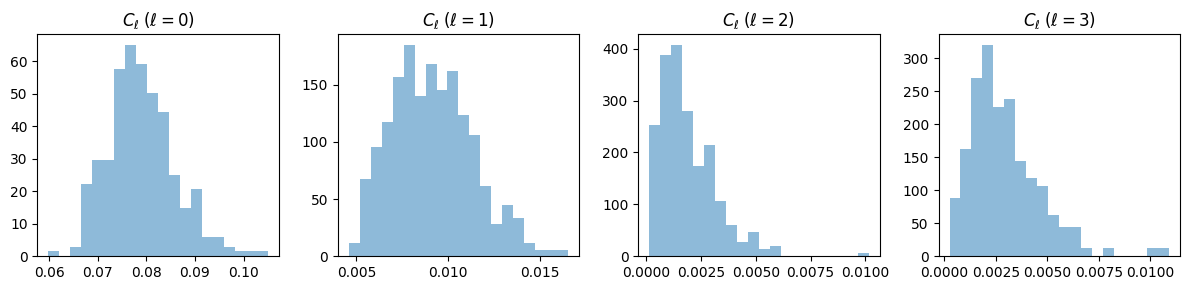

In [28]:
nbins = 20
fig, ax = plt.subplots(ncols=l_max + 1, figsize=(12, 3))

for i in range(0, l_max + 1):
    ax[i].hist(CL[i], bins=nbins, density=True, alpha=0.5)
    ax[i].set_title(r"$C_{\ell} \; (\ell = " + str(i) + ")$")
plt.tight_layout()

### - Plot the distribution of the CLs rescaled by the uncertainties

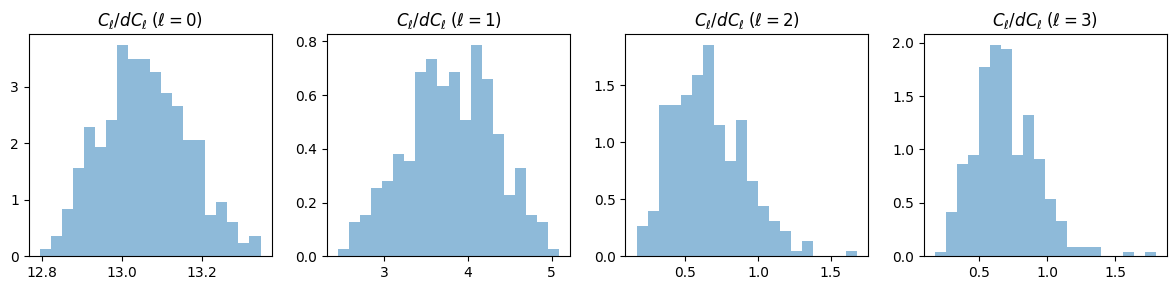

In [29]:
nbins = 20
fig, ax = plt.subplots(ncols=l_max + 1, figsize=(12, 3))

for i in range(0, l_max + 1):
    ax[i].hist(CL[i] / dCL[i], bins=nbins, density=True, alpha=0.5)
    ax[i].set_title(r"$C_{\ell} / dC_{\ell} \; (\ell = " + str(i) + ")$")
plt.tight_layout()